In [0]:
!pip install tensorflow-gpu

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamzaraouzi","key":"28388e813c3436f16140fd50d764a55c"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp  kaggle.json  ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:00<00:00, 67.1MB/s]
100% 2.29G/2.29G [01:00<00:00, 40.5MB/s]


In [5]:
from zipfile import ZipFile
file_name="chest-xray-pneumonia.zip"
with ZipFile(file_name,"r") as zip :
  zip.extractall()
  print('Done')

Done


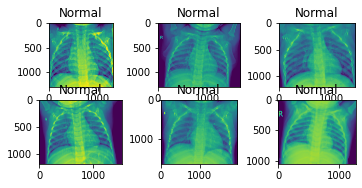

In [6]:
import matplotlib.pyplot as plt 
import os
from matplotlib.image import imread
folder='chest_xray/chest_xray/train/NORMAL/'
ex=os.listdir(folder)
for i in range(6):
  plt.subplot(330+1+i)
  image = imread(folder+ex[i])
  plt.title('Normal')
  plt.imshow(image)
plt.show()

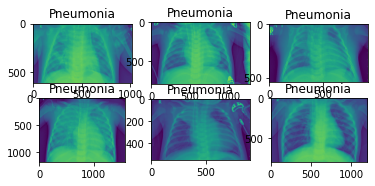

In [7]:
import matplotlib.pyplot as plt 
import os
from matplotlib.image import imread
folder='chest_xray/chest_xray/train/PNEUMONIA/'
ex=os.listdir(folder)
for i in range(6):
  plt.subplot(330+1+i)
  image = imread(folder+ex[i])
  plt.title('Pneumonia')
  plt.imshow(image)
plt.show()

In [8]:
input_path='chest_xray/chest_xray/'
for s in ['train','val','test']:
  n_normal =len(os.listdir(input_path+s+'/NORMAL')) 
  n_infect =len(os.listdir(input_path+s+'/PNEUMONIA'))
  print('Set {} ,Normal images : {} , peneumonia images : {}'.format(s,n_normal,n_infect))

Set train ,Normal images : 1342 , peneumonia images : 3876
Set val ,Normal images : 9 , peneumonia images : 9
Set test ,Normal images : 234 , peneumonia images : 390


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
train_it = datagen.flow_from_directory('chest_xray/chest_xray/train/',
		class_mode='binary', batch_size=32, shuffle=True,target_size=(150, 150))

val_it =  datagen.flow_from_directory('chest_xray/chest_xray/val/',
		class_mode='binary', batch_size=32,shuffle=True ,target_size=(150, 150))

test_it = datagen.flow_from_directory('chest_xray/chest_xray/test/',
		class_mode='binary', batch_size=32,shuffle=True ,target_size=(150, 150))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
from tensorflow.keras.layers import Dense,Conv2D,Flatten,BatchNormalization,Dropout,MaxPool2D,SeparableConv2D,Input
from tensorflow.keras.models import  Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
inputs = Input(shape=(150,150, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [7]:
history = model.fit(train_it,steps_per_epoch=len(train_it),epochs=30 ,
                              validation_data=test_it,validation_steps=len(test_it),callbacks=[checkpoint],verbose=2) 

Epoch 1/30
163/163 - 54s - loss: 0.7319 - accuracy: 0.7765 - val_loss: 6.9914 - val_accuracy: 0.6250
Epoch 2/30
163/163 - 54s - loss: 0.2286 - accuracy: 0.9114 - val_loss: 14.7047 - val_accuracy: 0.6250
Epoch 3/30
163/163 - 54s - loss: 0.1650 - accuracy: 0.9413 - val_loss: 2.2344 - val_accuracy: 0.6282
Epoch 4/30
163/163 - 54s - loss: 0.1430 - accuracy: 0.9477 - val_loss: 1.8596 - val_accuracy: 0.4231
Epoch 5/30
163/163 - 54s - loss: 0.1203 - accuracy: 0.9582 - val_loss: 5.5134 - val_accuracy: 0.6250
Epoch 6/30
163/163 - 54s - loss: 0.1266 - accuracy: 0.9582 - val_loss: 1.0250 - val_accuracy: 0.6891
Epoch 7/30
163/163 - 54s - loss: 0.0997 - accuracy: 0.9638 - val_loss: 0.4732 - val_accuracy: 0.6827
Epoch 8/30
163/163 - 54s - loss: 0.0807 - accuracy: 0.9739 - val_loss: 1.2278 - val_accuracy: 0.6282
Epoch 9/30
163/163 - 53s - loss: 0.0702 - accuracy: 0.9778 - val_loss: 0.5483 - val_accuracy: 0.8093
Epoch 10/30
163/163 - 54s - loss: 0.0750 - accuracy: 0.9732 - val_loss: 1.2833 - val_accur

In [8]:
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 76.603


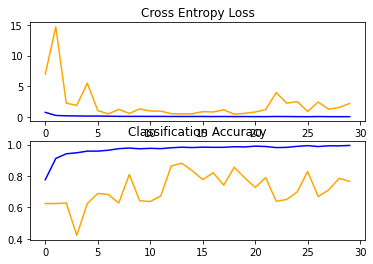

In [9]:
import matplotlib.pyplot as plt


plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

In [10]:
model.load_weights('best_weights.hdf5')
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 85.577
